## Setup

In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 83.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import multiprocessing
import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

N_THREADS = multiprocessing.cpu_count()
N_FOLDS = 5
TEST_SIZE = 0.2
TIMEOUT = 500
TARGET_NAME = 'Close'
RANDOM_STATE = 59
np.random.seed(RANDOM_STATE)
random.seed(59)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [3]:
# dataset with DJIA index prices by days in chronological order
ds_path = '/kaggle/input/stock-market-prediction-and-sentimental-analysis'
os.listdir(ds_path)

['sample_submission.csv',
 'Combined_News_DJIA(train).csv',
 'Test_DJIA_Table.csv',
 'TEST_Redit_news.csv',
 'RedditNews(train).csv',
 'Test_Combined_News.csv',
 'DJIA_table(train).csv']

## Data

In [4]:
train_df = pd.read_csv(os.path.join(ds_path, 'DJIA_table(train).csv'))
test_df = pd.read_csv(os.path.join(ds_path, 'Test_DJIA_Table.csv'))
sample_df = pd.read_csv(os.path.join(ds_path, 'sample_submission.csv'))

train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d-%m-%Y')
test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d-%m-%Y')

# reversed in original date
train_df = train_df.sort_values(by='Date')
test_df = test_df.sort_values(by='Date')

col_type = {}
for col in train_df.columns: 
    col_type[col] = train_df[col].dtype
print(col_type, end='\n\n')

print(train_df.shape, train_df.columns)
print(test_df.shape, test_df.columns)
print(sample_df.shape, sample_df.columns)

{'Date': dtype('<M8[ns]'), 'Open': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Close': dtype('float64'), 'Volume': dtype('int64'), 'Adj Close': dtype('float64')}

(1863, 7) Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
(126, 5) Index(['Date', 'Open', 'High', 'Low', 'Volume'], dtype='object')
(126, 2) Index(['Id', 'Close'], dtype='object')


In [5]:
# redundant column
close_cols_nonequal = (train_df['Close'] != train_df['Adj Close']).sum()
if close_cols_nonequal == 0:
    print('deleting "Adj Close"')
    train_df = train_df.drop('Adj Close', axis=1)

deleting "Adj Close"


In [6]:
# 'Volume' to float64
train_df['Volume'] = train_df['Volume'].astype(np.float64)
test_df['Volume'] = test_df['Volume'].astype(np.float64)

In [7]:
train_df.head()

,Date,Open,High,Low,Close,Volume
1862,2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000.0
1861,2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000.0
1860,2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000.0
1859,2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000.0
1858,2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000.0


In [8]:
train_df.describe()

,Date,Open,High,Low,Close,Volume
count,1863,1863.000000,1863.000000,1863.000000,1863.000000,1.863000e+03
mean,2012-04-20 00:21:38.550724608,13204.195193,13285.564853,13119.570584,13208.104880,1.662263e+08
min,2008-08-08 00:00:00,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06
25%,2010-06-15 12:00:00,10753.084960,10859.745115,10651.370115,10752.444825,1.018500e+08
50%,2012-04-19 00:00:00,12806.450200,12877.179690,12744.469730,12810.540040,1.392500e+08
75%,2014-02-26 12:00:00,16254.470215,16354.635255,16133.435060,16257.040040,1.972900e+08
max,2015-12-31 00:00:00,18315.060550,18351.359380,18272.560550,18312.390630,6.749200e+08
std,NaN,3080.633638,3072.306029,3089.839032,3081.319402,9.557187e+07


In [9]:
print(train_df.isnull().values.any(), test_df.isnull().values.any())

train_num_cols = [col for col in train_df.columns if train_df[col].dtype == np.float64]
test_num_cols = [col for col in test_df.columns if test_df[col].dtype == np.float64]

print(np.isinf(train_df[train_num_cols].values).any(), 
      np.isinf(test_df[test_num_cols].values).any())

False False
False False


## Baseline

In [10]:
train_df_X = train_df.drop(TARGET_NAME, axis=1)
train_df_y = train_df[TARGET_NAME]
train_X, valid_X, train_y, valid_y = train_test_split(train_df_X, train_df_y,
                                                      test_size=TEST_SIZE, 
                                                      random_state=RANDOM_STATE)
print(train_X.shape, valid_X.shape, train_y.shape, valid_y.shape, test_df.shape)

(1490, 5) (373, 5) (1490,) (373,) (126, 5)


In [11]:
# standard_scaler.fit_transform(train_x) and .transform(test_x)

x_num_cols = [col for col in train_X.columns if train_X[col].dtype == np.float64]
print(x_num_cols)
scaler = StandardScaler()
train_X[x_num_cols] = scaler.fit_transform(train_X[x_num_cols])
valid_X[x_num_cols] = scaler.transform(valid_X[x_num_cols])
test_df[x_num_cols] = scaler.transform(test_df[x_num_cols])
print(train_X.shape, valid_X.shape, test_df.shape)

['Open', 'High', 'Low', 'Volume']
(1490, 5) (373, 5) (126, 5)


Data is pretty clear.

As a baseline I'll fit lightautoml regression model without any EDA and feature engineering.

The goal is to predict "Close" price of a stock based on "Open", "High", "Low", "Volume" features.

In [12]:
task = Task('reg')
roles = {'target': TARGET_NAME, 'date': 'Date'}
RD = ReportDeco(output_path='/kaggle/working/tabularAutoML_model_report')
automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

train_data_automl = pd.concat([train_X, train_y], axis=1)
print(train_data_automl.shape)

(1490, 6)


In [13]:
train_data_automl.head()

,Date,Open,High,Low,Volume,Close
919,2012-05-07,-0.067917,-0.090417,-0.061653,-0.582289,13008.53027
524,2013-12-02,0.922390,0.902184,0.914553,-0.765405,16008.76953
1486,2010-02-05,-1.052020,-1.072671,-1.076271,1.493238,10012.23047
706,2013-03-14,0.392767,0.394732,0.419059,-0.505755,14539.13965
572,2013-09-24,0.700205,0.685931,0.701238,-0.840369,15334.58984


In [14]:
t0 = time.perf_counter()
out_of_fold_predictions = automl_rd.fit_predict(train_data_automl, roles=roles, verbose=1)
t1 = time.perf_counter()

[14:25:29] Stdout logging level is INFO.
[14:25:29] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:25:29] Task: reg

[14:25:29] Start automl preset with listed constraints:
[14:25:29] - time: 500.00 seconds
[14:25:29] - CPU: 4 cores
[14:25:29] - memory: 16 GB

[14:25:29] Train data shape: (1490, 6)

[14:25:40] Layer 1 train process start. Time left 489.10 secs
[14:25:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:25:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2775.65797798437
[14:25:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:25:46] Time left 483.27 secs

[14:25:48] Selector_LightGBM fitting and predicting completed
[14:25:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:26:07] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -8602.427199446935
[14:26:07] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:26:07] Start hyperparameters optimization for Lvl_0_Pipe

Optimization Progress:   1%|          | 1/101 [00:06<11:16,  6.76s/it, best_trial=0, best_value=-4.99e+3]

[14:26:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[14:26:14] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[14:26:18] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -8534.530635248173
[14:26:18] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[14:26:18] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[14:26:21] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -18587.42268033305
[14:26:21] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[14:26:21] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [00:40<00:00,  2.51it/s, best_trial=84, best_value=-1.66e+4]

[14:27:01] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[14:27:01] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[14:27:03] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -18487.404346677424
[14:27:03] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[14:27:03] Time left 406.53 secs

[14:27:03] Layer 1 training completed.

[14:27:03] Blending: optimization starts with equal weights. Score = -7912.8461049
[14:27:03] Blending: iteration 0: score = -2775.6579780, weights = [1. 0. 0. 0. 0.]
[14:27:03] Blending: no improvements for score. Terminated.

[14:27:03] Blending: best score = -2775.6579780, best weights = [1. 0. 0. 0. 0.]
[14:27:03] Automl preset training completed in 93.55 seconds

[14:27:03] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 



In [15]:
print(f'training took {(t1-t0)/60:.2f} mins.')

training took 1.60 mins.


In [16]:
valid_data_automl = pd.concat([valid_X, valid_y], axis=1)
valid_preds = automl_rd.predict(valid_data_automl)
print(valid_data_automl.shape, valid_preds.shape)

(373, 6) (373, 1)


In [17]:
# ?
print(type(valid_preds[:5]), isinstance(valid_preds, np.ndarray))

<class 'lightautoml.dataset.np_pd_dataset.NumpyDataset'> False


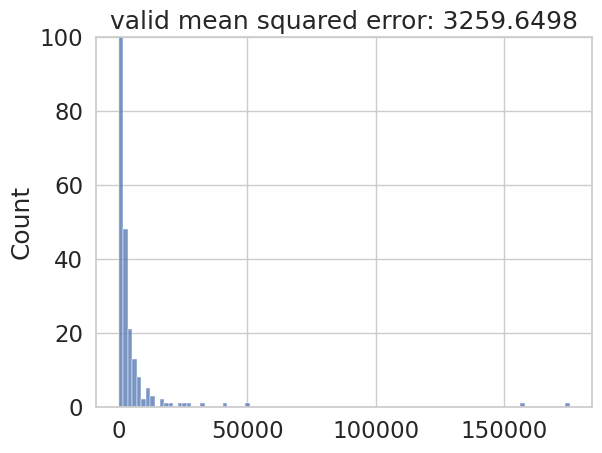

In [18]:
valid_squared_errors = (valid_y.to_numpy() - valid_preds.data[:, 0]) ** 2
plt.title(f'valid mean squared error: {valid_squared_errors.mean():.4f}')
sns.histplot(data=valid_squared_errors, stat='count', bins=100)
plt.ylim(0, 100);

In [19]:
valid_squared_errors.max()

175709.15219431478

<Axes: title={'center': 'valid root mean squared error: 57.0933'}, ylabel='Count'>

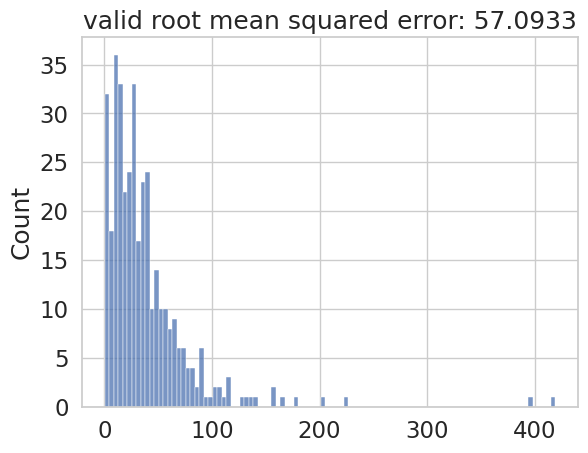

In [20]:
plt.title(f'valid root mean squared error: {np.sqrt(valid_squared_errors.mean()):.4f}')
sns.histplot(data=np.sqrt(valid_squared_errors), stat='count', bins=100)

In [21]:
test_df_automl = pd.concat([test_df, pd.DataFrame({'Close': np.zeros(test_df.shape[0])})], axis=1)
test_preds = automl_rd.predict(test_df_automl)

In [22]:
submission_df = pd.DataFrame({'Id': range(1, test_df.shape[0]+1), 'Close': test_preds.data[:, 0]})
submission_df.to_csv('/kaggle/working/stocks_submission.csv', index=False)

# score on private data is a very big number, it's strange, but everyone there has very big numbers,
# basically this submission is bottom 3 score

We can see that resulting lightautoml model is just simplest linear regression without any ensemble. It probably means that our current features are very shallow and more complex models are easily overfitting on data and getting even higher errors.

Another problem to look for is outliers, which probably contributes to bad generalization.

After additional feature engineering, filtering outliers with three-sigma rule etc., I'll fit another lightautoml_reg and some other classic ML models for representative comparison.

## EDA

In [23]:
# check for missed days in train data
days_range = (train_df['Date'].max() - train_df['Date'].min()).days
missed_days_cnt = 0
for i in range(1, train_df.shape[0]):
    if (train_df.iloc[i]['Date'] - train_df.iloc[i-1]['Date']).days > 1:
        missed_days_cnt += 1
print(f'missed days: {missed_days_cnt} ({missed_days_cnt/days_range*100:.0f}%)')

missed days: 404 (15%)


In [24]:
# check for missed days in test data
days_range = (test_df['Date'].max() - test_df['Date'].min()).days
missed_days_cnt = 0
for i in range(1, test_df.shape[0]):
    if (test_df.iloc[i]['Date'] - test_df.iloc[i-1]['Date']).days > 1:
        missed_days_cnt += 1
print(f'missed days: {missed_days_cnt} ({missed_days_cnt/days_range*100:.0f}%)')

missed days: 25 (14%)


In [25]:
# if we have missed days in TEST data it's probably not a good idea to try to fill them in TRAIN data

<Axes: xlabel='Date', ylabel='Close'>

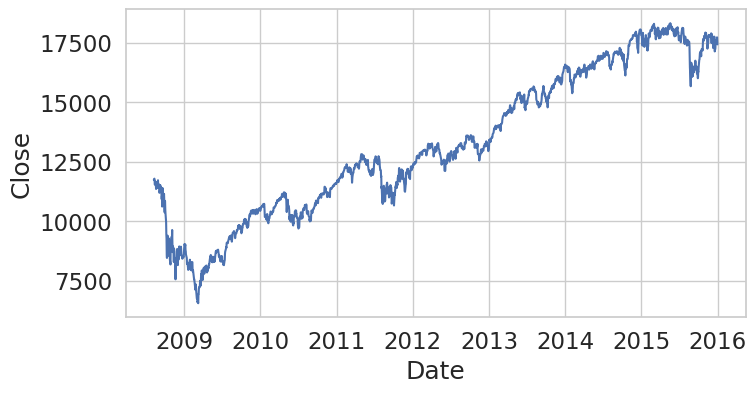

In [26]:
# general price line (looks real)
plt.figure(figsize=(8, 4))
sns.lineplot(x=train_df['Date'], y=train_df['Close'])

In [27]:
# we have a general trend here, but we're predicting absolute value of price, so I won't try to substract it

<Axes: xlabel='Date', ylabel='Volume'>

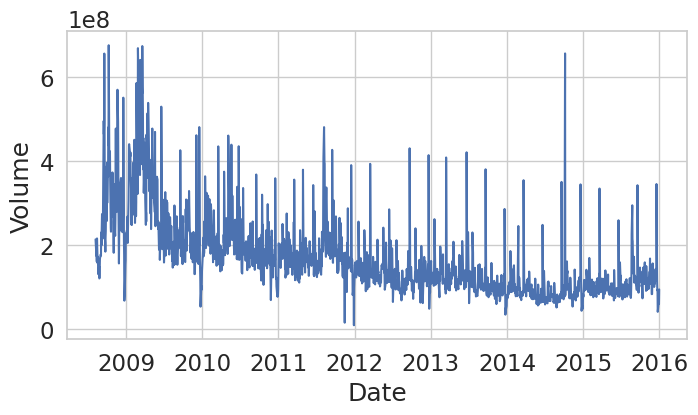

In [28]:
# Volume over time
# less volume over time but bigger 'Close' price
plt.figure(figsize=(8, 4))
sns.lineplot(x=train_df['Date'], y=train_df['Volume'])

In [29]:
# looks like we have outliers in Volume

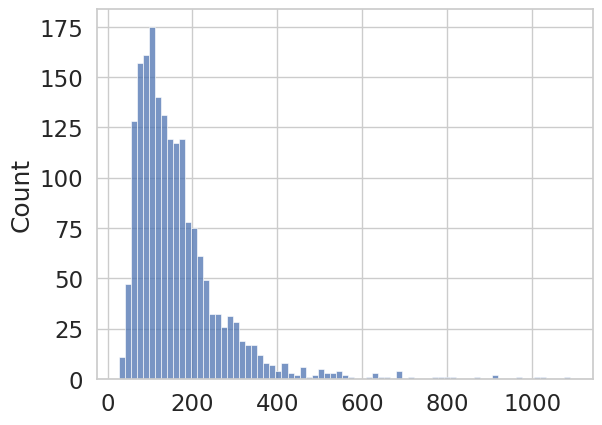

In [30]:
# (High - Low) delta histogram

sns.histplot(data=train_df['High'] - train_df['Low'], stat='count', bins=75);

<Axes: ylabel='Count'>

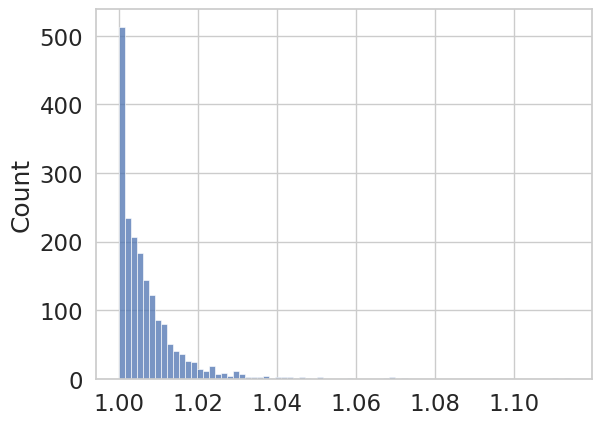

In [31]:
# High to Open ratio
sns.histplot(data=train_df['High'] / train_df['Open'], stat='count', bins=75)

<Axes: xlabel='Close', ylabel='Count'>

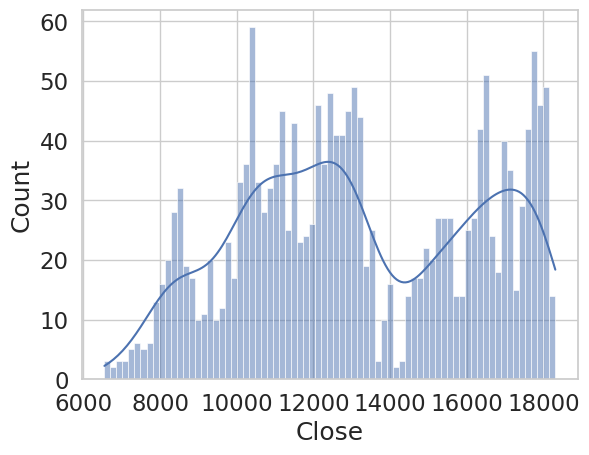

In [32]:
# target 'Close' distribution
sns.histplot(train_df['Close'], kde=True, bins=75)

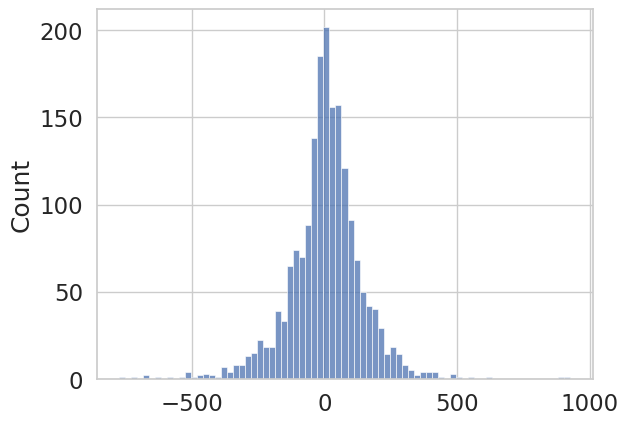

In [33]:
# return (Close - Open) delta histogram
# normally distributed
sns.histplot(data=train_df['Close'] - train_df['Open'], stat='count', bins=75);

<Axes: >

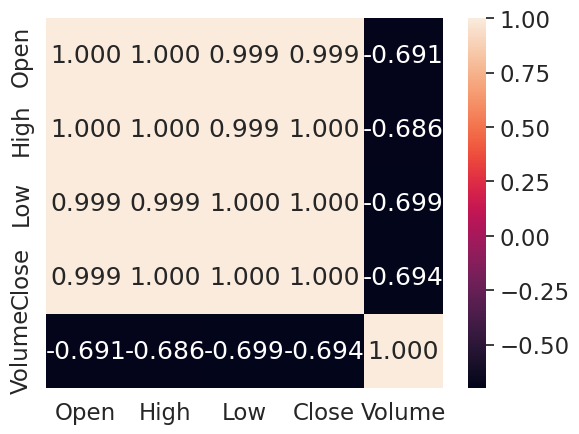

In [34]:
# correlation heatmap, looks very suspicious
# maybe the problem is that our features aren't very informative for now and after
# feature engineering we'll get better heatmap
sns.heatmap(train_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, fmt='.3f')

In [35]:
# outliers calc for each column

def find_outliers_three_sig(df, exclude=None):
    result = pd.DataFrame(index=df.index)
    if not exclude:
        cols = [col for col in df.columns if col]
    else:
        cols = [col for col in df.columns if col not in exclude]

    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # bool mask
        result[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    return result

In [36]:
outlier_count_df = find_outliers_three_sig(train_df, exclude=['Close', 'Date'])
print(outlier_count_df.sum())

Open_outlier       0
High_outlier       0
Low_outlier        0
Volume_outlier    40
dtype: int64


In [37]:
# capping outliers with border values,
# we don't want to use mean or median because we'd lost info about big deals

def clip_outliers(df, cols=None):
    assert cols is not None
    df_clean = df.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        lower = mean - 3 * std
        upper = mean + 3 * std
            
        df_clean[col] = df[col].clip(lower=lower, upper=upper)
    return df_clean

<Axes: xlabel='Date', ylabel='Volume'>

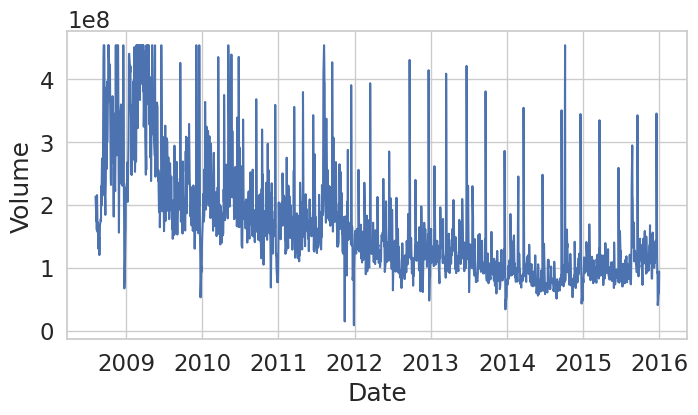

In [38]:
train_df_clean = clip_outliers(train_df, ['Volume'])
plt.figure(figsize=(8, 4))
sns.lineplot(x=train_df_clean['Date'], y=train_df_clean['Volume'])

## Feature engineering

the main problem with this comptetition as I undertand - for the test data we're predicting today's Close price based on today's Open, High, Low and Volume, and that's not usable in real world scenario, because we can't know exact High, Low and Volume before the end of the day.

I've choose this competition over more realistic one (https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data) because it looked too hard.

to compensate this issue and fix data leakage, I will shift train_df['Close'] by 1 day, train model to predict 'Close' price of the next day based on current day stats, and just pretend that on the test_df we're also predicting 'Close' for the next day.

In [39]:
train_df = clip_outliers(train_df, ['Volume'])
test_df = clip_outliers(test_df, ['Volume'])

In [40]:
train_df['Target'] = train_df['Close'].shift(-1)
train_df = train_df.dropna()  # drop last day
train_df = train_df.drop('Close', axis=1)
print(train_df.shape)

(1862, 6)


                High_Low_delta    Target
High_Low_delta        1.000000 -0.438459
Target               -0.438459  1.000000


<Axes: xlabel='High_Low_delta', ylabel='Target'>

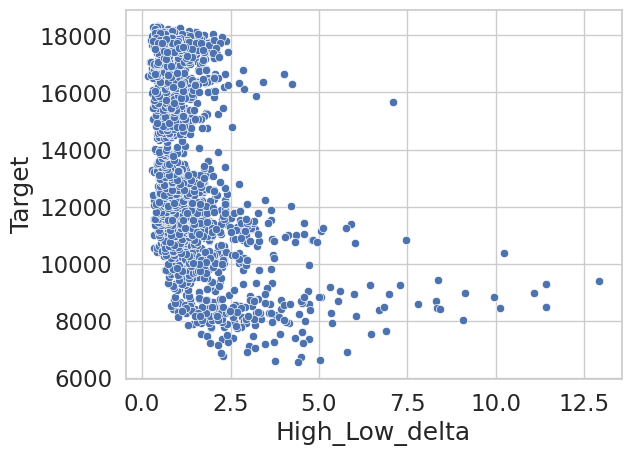

In [41]:
# High - Low delta from EDA (but in ratio)
train_df['High_Low_delta'] = (train_df['High'] - train_df['Low']) / train_df['Low'] * 100

# higher volatility -> often lower price tomorrow (-0.44 corr)
print(train_df[['High_Low_delta', 'Target']].corr())
sns.scatterplot(x=train_df['High_Low_delta'], y=train_df['Target'])

In [42]:
# additional ratios
train_df['Open_to_High'] = train_df['High'] / train_df['Open']
train_df['Open_to_Low'] = train_df['Low'] / train_df['Open']

# I can interpret that if the High rises too much relative to Open -> a lot of people try to
# sell the stock for profit and 'Close' on the next day will drop
print(train_df[['Open_to_High', 'Target']].corr())

# inverse for Open_to_Low, if stock goes cheap -> a lot of people will buy it (hoping that in the future
# price will rise), so demand and 'Close' price rises
print(train_df[['Open_to_Low', 'Target']].corr())

              Open_to_High    Target
Open_to_High      1.000000 -0.275482
Target           -0.275482  1.000000
             Open_to_Low    Target
Open_to_Low     1.000000  0.292972
Target          0.292972  1.000000


In [43]:
# some stock-specific feature ideas from
# https://medium.com/@zhonghong9998/predicting-stock-returns-a-guide-to-feature-engineering-for-financial-data-bbf6700b11d7

In [44]:
# additional Date features for capturing seasonality and inderect detrending target
train_df['Day_of_Week'] = train_df['Date'].dt.dayofweek
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['Year'] = train_df['Date'].dt.year

In [45]:
# rolling stat to capture short-term trends and volatility
# (reverse shift in our case of predicting next day price)

days_range = [3, 5, 7]
for col in ['Open', 'Volume', 'High', 'Low']:
    for dr in days_range:
        train_df[f'Rolling_Mean_{col}_{dr}'] = train_df[col].shift(1).rolling(window=dr).mean()
        train_df[f'Rolling_Std_{col}_{dr}'] = train_df[col].shift(1).rolling(window=dr).std()

print(train_df[['Rolling_Mean_Volume_5', 'Target']].corr())
print(train_df[['Rolling_Std_Volume_5', 'Target']].corr())

                       Rolling_Mean_Volume_5    Target
Rolling_Mean_Volume_5               1.000000 -0.807972
Target                             -0.807972  1.000000
                      Rolling_Std_Volume_5    Target
Rolling_Std_Volume_5              1.000000 -0.325339
Target                           -0.325339  1.000000


In [46]:
# lagged features to captule historical info
lag_ranges = [1, 3, 5, 7]
for col in ['Open', 'Volume', 'High', 'Low']:
    for lag in lag_ranges:
        train_df[f'{col}_lag_{lag}'] = train_df[col].shift(lag)

In [47]:
# same features for test_df
test_df['High_Low_delta'] = (test_df['High'] - test_df['Low']) / test_df['Low'] * 100
test_df['Open_to_High'] = test_df['High'] / test_df['Open']
test_df['Open_to_Low'] = test_df['Low'] / test_df['Open']
test_df['Day_of_Week'] = test_df['Date'].dt.dayofweek
test_df['Day'] = test_df['Date'].dt.day
test_df['Month'] = test_df['Date'].dt.month
test_df['Year'] = test_df['Date'].dt.year

days_range = [3, 5, 7]
for col in ['Open', 'Volume', 'High', 'Low']:
    for dr in days_range:
        test_df[f'Rolling_Mean_{col}_{dr}'] = test_df[col].shift(1).rolling(window=dr).mean()
        test_df[f'Rolling_Std_{col}_{dr}'] = test_df[col].shift(1).rolling(window=dr).std()

lag_ranges = [1, 3, 5, 7]
for col in ['Open', 'Volume', 'High', 'Low']:
    for lag in lag_ranges:
        test_df[f'{col}_lag_{lag}'] = test_df[col].shift(lag)

In [48]:
# I will delete features for which correlation with target is abnormally large
# except original dataset features Open, High, Low, Volume

def remove_high_correlated_with_target(df, target_col, exclude_cols=None, threshold=0.95):
    if exclude_cols is None:
        exclude_cols = []
    exclude_cols = exclude_cols + [target_col]

    corr_with_target = df.corr()[target_col].abs()
    high_corr_cols = [
        col for col in corr_with_target.index
        if col not in exclude_cols and corr_with_target[col] >= threshold
    ]

    df_filtered = df.drop(columns=high_corr_cols)   
    return df_filtered, high_corr_cols

In [49]:
# removing corr cols in train_df
# train_df, deleted_cols = remove_high_correlated_with_target(train_df, 'Target', ['Date', 'Open', 'High', 'Low', 'Volume'])
# removing same cols in test_df
# test_df = test_df.drop(columns=deleted_cols)
# print(deleted_cols)
# decided not to remove them after all

<Axes: >

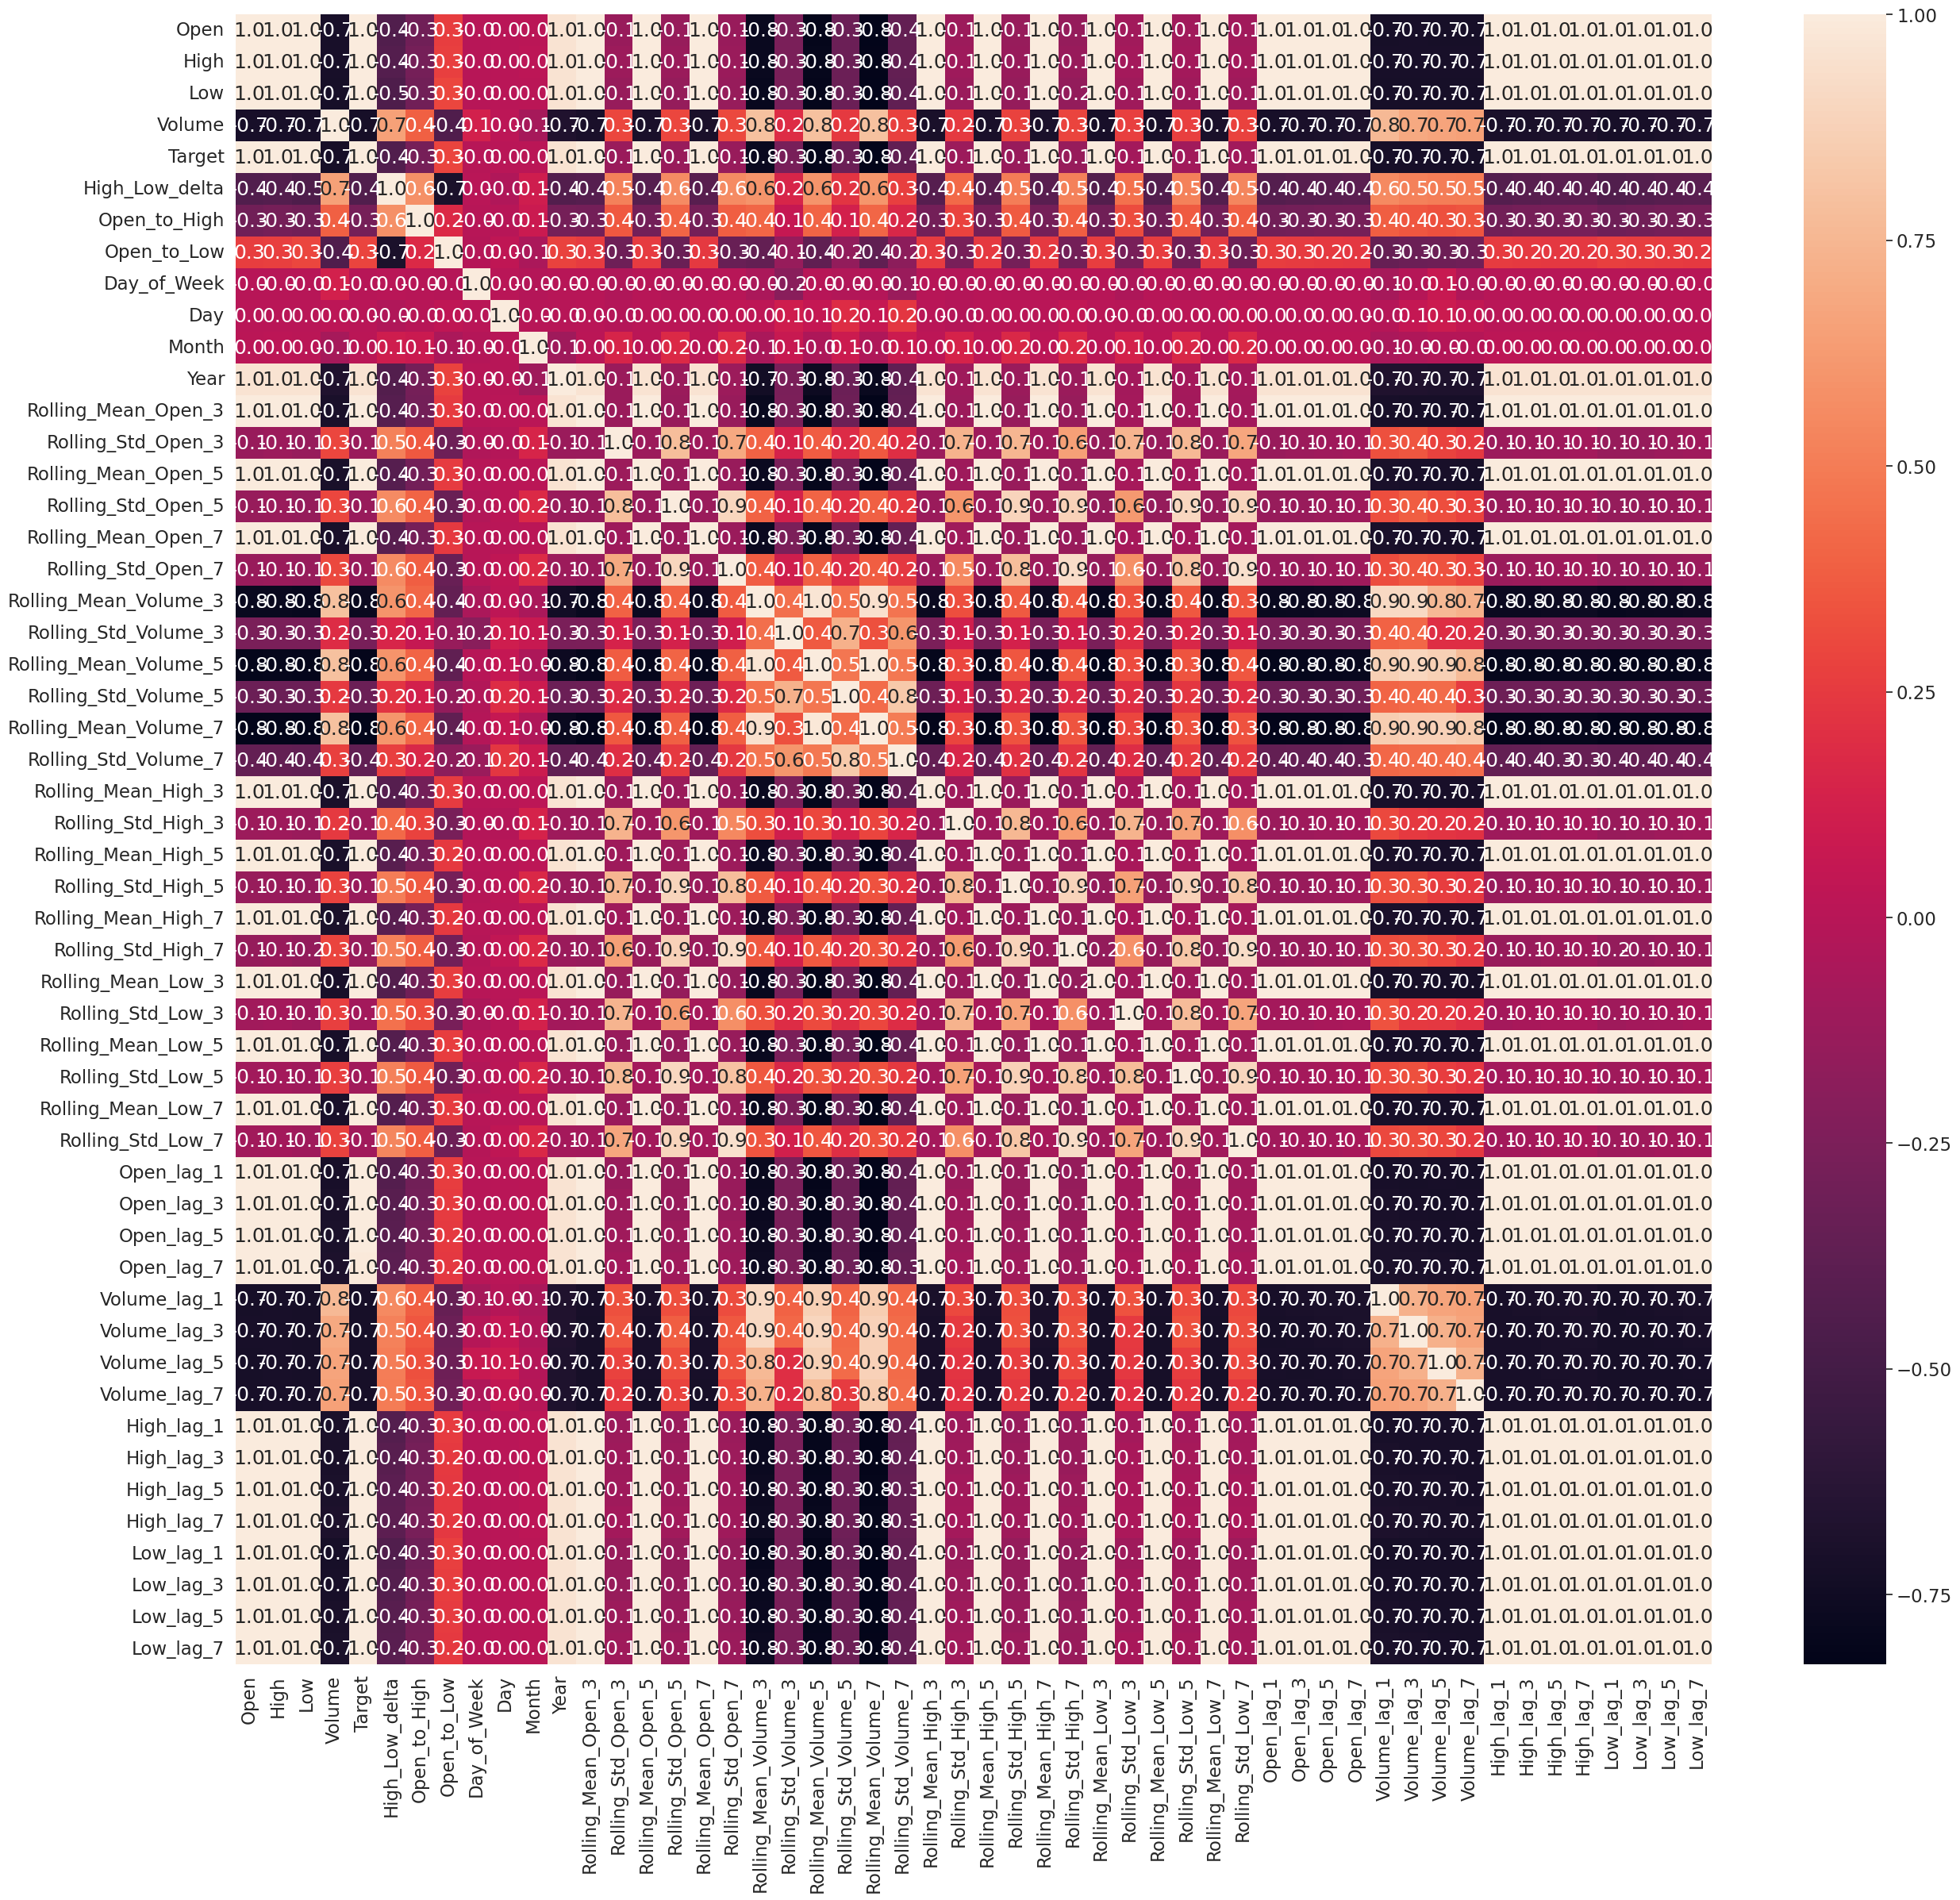

In [51]:
# new correlation heatmap, most important to look at correlations with Target
ccols = [col for col in train_df.columns if col not in ['Date']]
plt.figure(figsize=(30,27))
sns.heatmap(train_df[ccols].corr(), annot=True, fmt='.1f')

In [52]:
# looks fine, let's fit new TabularAutoML model

# Better baseline

In [53]:
from sklearn.impute import KNNImputer
# imputer will be used to fill NaN's that were created in lag and rolling features
# KKN will take closest neighbors for filling nan's, that's good for time series
imputer = KNNImputer(n_neighbors=5)

In [54]:
TARGET_NAME = 'Target'
train_df_X = train_df.drop(TARGET_NAME, axis=1)
train_df_y = train_df[TARGET_NAME]
train_X, valid_X, train_y, valid_y = train_test_split(train_df_X, train_df_y,
                                                      test_size=TEST_SIZE, 
                                                      random_state=RANDOM_STATE)
print(train_X.shape, valid_X.shape, train_y.shape, valid_y.shape, test_df.shape)

(1489, 52) (373, 52) (1489,) (373,) (126, 52)


In [55]:
# standard_scaler and KNNImputer: .fit_transform(train_x) and .transform(test_x)

x_num_cols = [col for col in train_X.columns if train_X[col].dtype == np.float64]
print(x_num_cols)
scaler = StandardScaler()
train_X[x_num_cols] = scaler.fit_transform(train_X[x_num_cols])
valid_X[x_num_cols] = scaler.transform(valid_X[x_num_cols])
test_df[x_num_cols] = scaler.transform(test_df[x_num_cols])


train_X[x_num_cols] = imputer.fit_transform(train_X[x_num_cols])
valid_X[x_num_cols] = imputer.transform(valid_X[x_num_cols])
test_df[x_num_cols] = imputer.transform(test_df[x_num_cols])
print(sum(train_X.isna().any()), sum(valid_X.isna().any()), sum(test_df.isna().any()))
print(train_X.shape, valid_X.shape, test_df.shape)

['Open', 'High', 'Low', 'Volume', 'High_Low_delta', 'Open_to_High', 'Open_to_Low', 'Rolling_Mean_Open_3', 'Rolling_Std_Open_3', 'Rolling_Mean_Open_5', 'Rolling_Std_Open_5', 'Rolling_Mean_Open_7', 'Rolling_Std_Open_7', 'Rolling_Mean_Volume_3', 'Rolling_Std_Volume_3', 'Rolling_Mean_Volume_5', 'Rolling_Std_Volume_5', 'Rolling_Mean_Volume_7', 'Rolling_Std_Volume_7', 'Rolling_Mean_High_3', 'Rolling_Std_High_3', 'Rolling_Mean_High_5', 'Rolling_Std_High_5', 'Rolling_Mean_High_7', 'Rolling_Std_High_7', 'Rolling_Mean_Low_3', 'Rolling_Std_Low_3', 'Rolling_Mean_Low_5', 'Rolling_Std_Low_5', 'Rolling_Mean_Low_7', 'Rolling_Std_Low_7', 'Open_lag_1', 'Open_lag_3', 'Open_lag_5', 'Open_lag_7', 'Volume_lag_1', 'Volume_lag_3', 'Volume_lag_5', 'Volume_lag_7', 'High_lag_1', 'High_lag_3', 'High_lag_5', 'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_5', 'Low_lag_7']
0 0 0
(1489, 52) (373, 52) (126, 52)


In [56]:
# as I undertand now, default cv with time series is a data leak, so we change it
from lightautoml.validation.np_iterators import TimeSeriesIterator
cv_iter = TimeSeriesIterator(train_X['Date'].astype('datetime64[ns]'), n_splits=N_FOLDS, sorted_kfold=False)

task = Task('reg', greater_is_better=False, metric='mae', loss='mae')
roles = {'target': TARGET_NAME, 'date': 'Date'}
RD = ReportDeco(output_path='/kaggle/working/tabularAutoML_model_report')
automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

train_data_automl = pd.concat([train_X, train_y], axis=1)
print(train_data_automl.shape)

(1489, 53)


In [57]:
t0 = time.perf_counter()
out_of_fold_predictions = automl_rd.fit_predict(train_data_automl, roles=roles, verbose=1, cv_iter=cv_iter)
t1 = time.perf_counter()

[14:28:26] Stdout logging level is INFO.
[14:28:26] Task: reg

[14:28:26] Start automl preset with listed constraints:
[14:28:26] - time: 500.00 seconds
[14:28:26] - CPU: 4 cores
[14:28:26] - memory: 16 GB

[14:28:26] Train data shape: (1489, 53)

[14:28:26] Layer 1 train process start. Time left 499.69 secs
[14:28:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:28:36] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -116.95348242590258
[14:28:36] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:28:36] Time left 489.76 secs

[14:28:38] Selector_LightGBM fitting and predicting completed
[14:28:38] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:28:48] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -127.51991872929787
[14:28:48] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:28:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 59.60 secs


Optimization Progress:  49%|████▊     | 49/101 [01:00<01:04,  1.24s/it, best_trial=12, best_value=-141]

[14:29:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[14:29:49] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[14:29:54] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -132.5955666015166
[14:29:54] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[14:29:54] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[14:30:01] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -163.46328665722086
[14:30:01] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[14:30:01] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 274.84 secs


Optimization Progress: 100%|██████████| 101/101 [02:04<00:00,  1.23s/it, best_trial=97, best_value=-170]

[14:32:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[14:32:06] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[14:32:11] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -156.82364724685138
[14:32:11] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[14:32:11] Time left 275.19 secs

[14:32:11] Layer 1 training completed.

[14:32:11] Blending: optimization starts with equal weights. Score = -123.9601643
[14:32:11] Blending: iteration 0: score = -113.3296382, weights = [0.6738445 0.3261555 0.        0.        0.       ]
[14:32:11] Blending: iteration 1: score = -113.3187254, weights = [0.6884186 0.3115813 0.        0.        0.       ]
[14:32:11] Blending: no improvements for score. Terminated.

[14:32:11] Blending: best score = -113.3187254, best weights = [0.6884186 0.3115813 0.        0.        0.       ]
[14:32:11] Automl preset training completed in 224.91 seconds

[14:32:11] Model description:
Final prediction for new objects (level 0) = 
	 0.68842 * (4 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.31158 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



In [58]:
print(f'training took {(t1-t0)/60:.2f} mins.')

training took 3.81 mins.


In [59]:
valid_data_automl = pd.concat([valid_X, valid_y], axis=1)
valid_preds = automl_rd.predict(valid_data_automl)
print(valid_data_automl.shape, valid_preds.shape)

(373, 53) (373, 1)


280865.32340213144


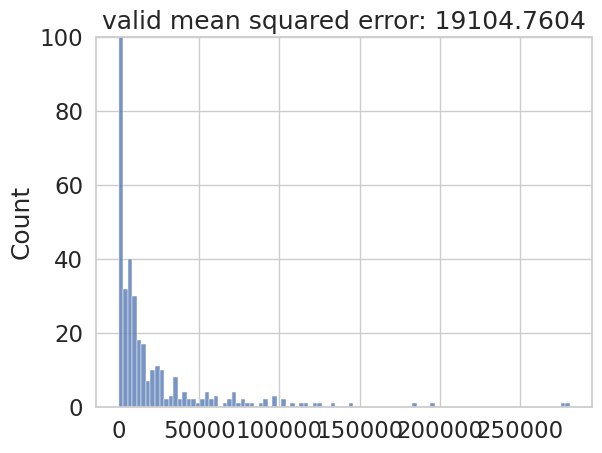

In [60]:
valid_squared_errors = (valid_y.to_numpy() - valid_preds.data[:, 0]) ** 2
plt.title(f'valid mean squared error: {valid_squared_errors.mean():.4f}')
print(valid_squared_errors.max())
sns.histplot(data=valid_squared_errors, stat='count', bins=100)
plt.ylim(0, 100);

<Axes: title={'center': 'valid root mean squared error: 138.2200'}, ylabel='Count'>

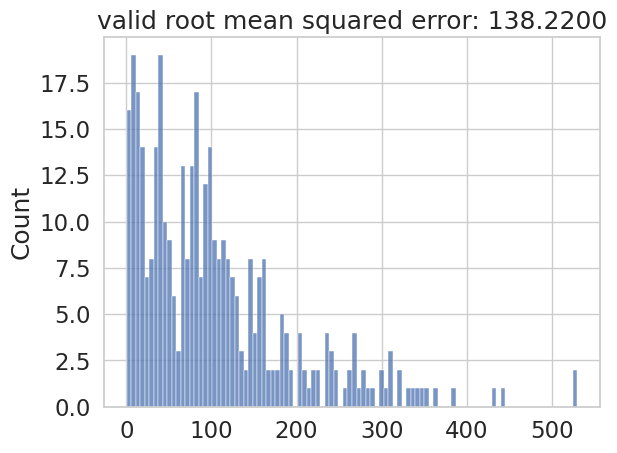

In [61]:
plt.title(f'valid root mean squared error: {np.sqrt(valid_squared_errors.mean()):.4f}')
sns.histplot(data=np.sqrt(valid_squared_errors), stat='count', bins=100)

<Axes: xlabel='Feature'>

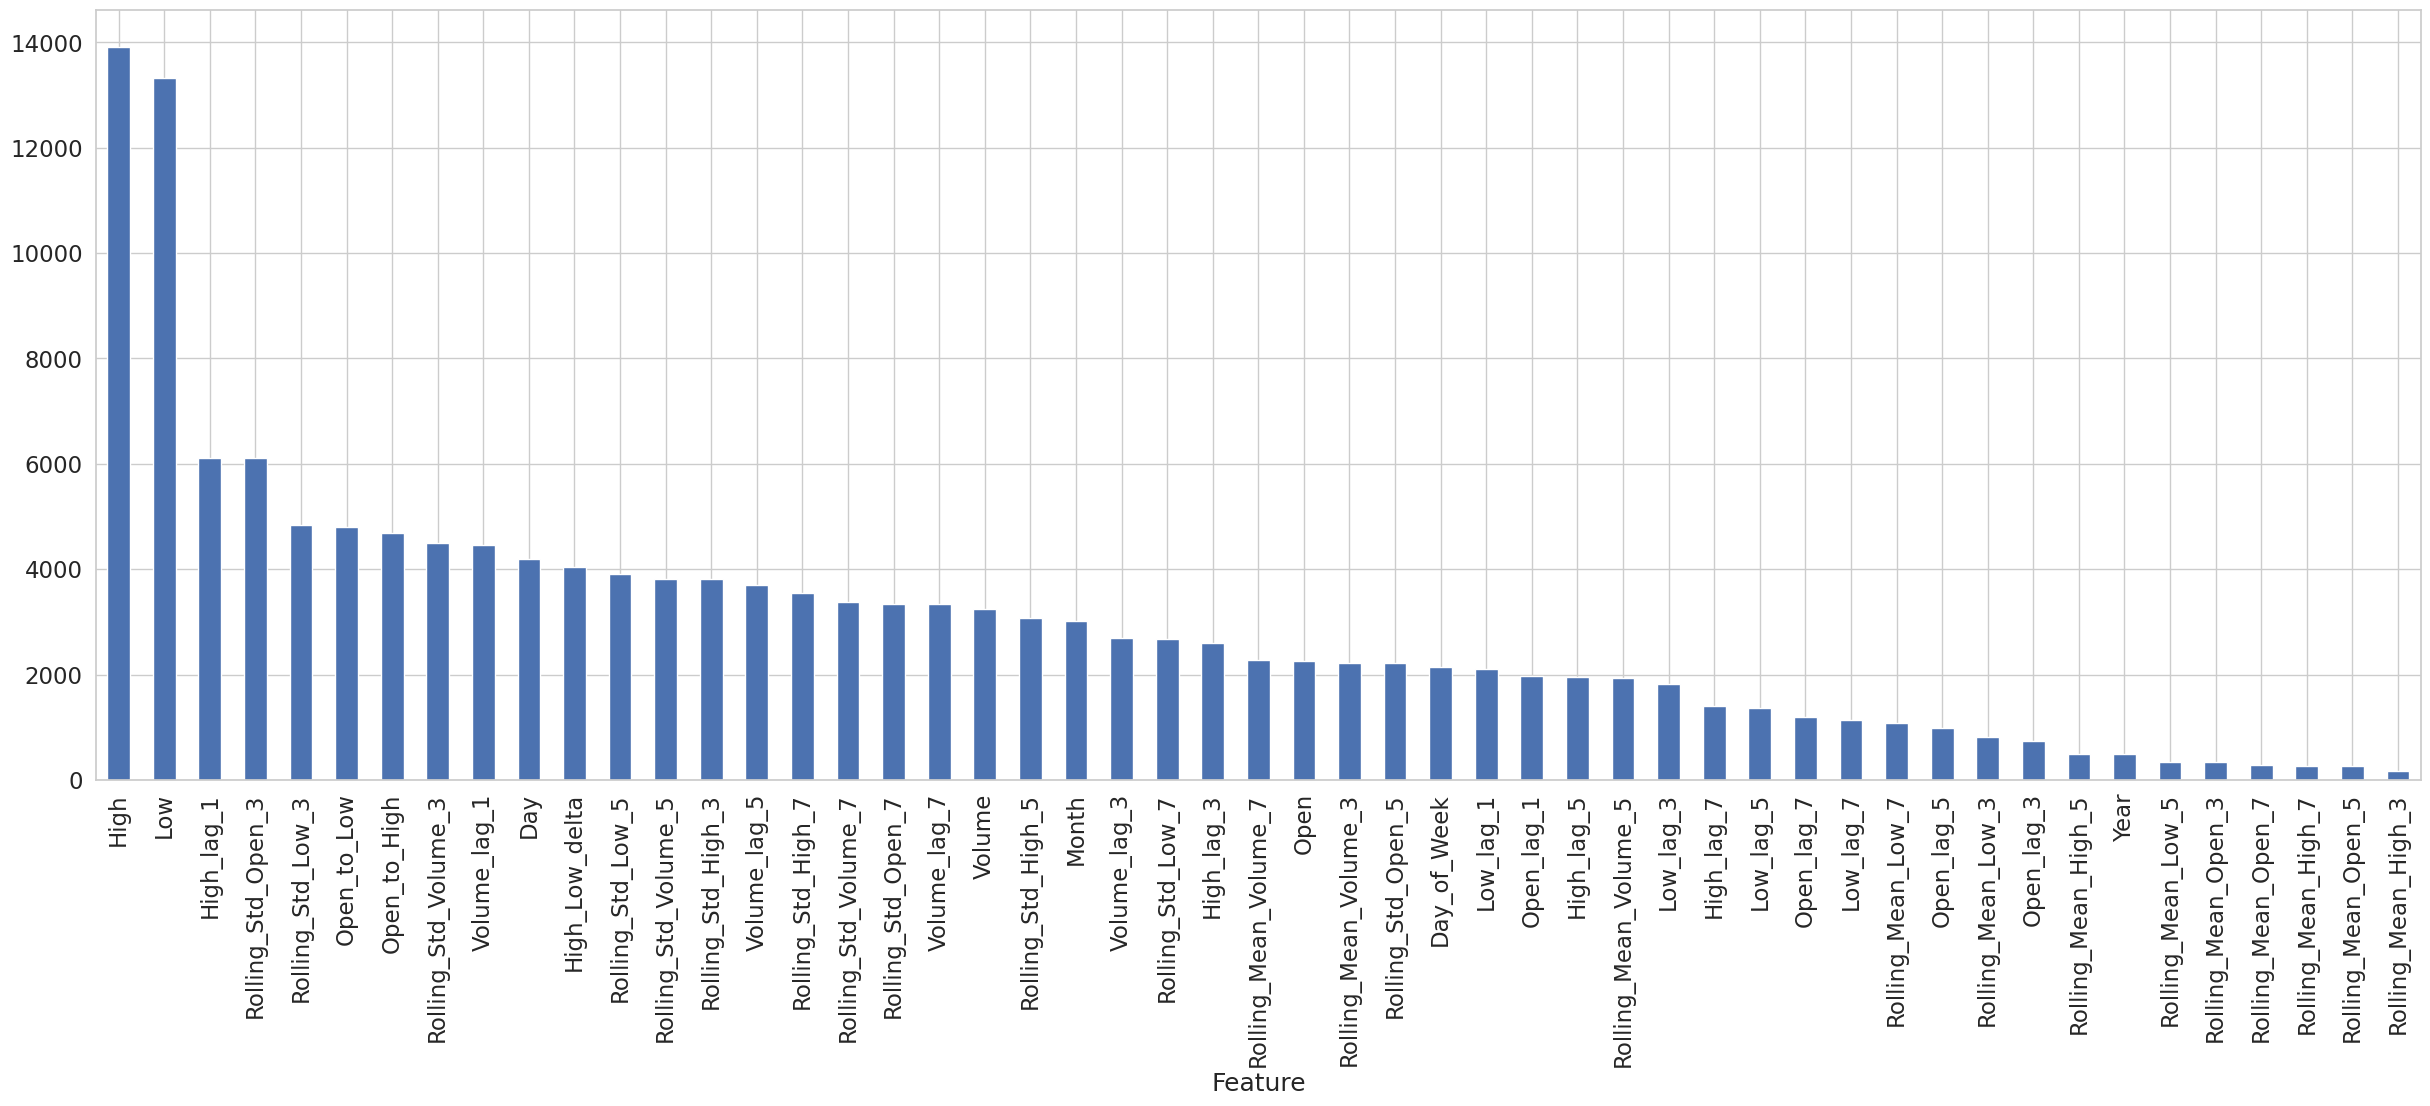

In [63]:
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [65]:
test_df_automl = pd.concat([test_df, pd.DataFrame({'Target': np.zeros(test_df.shape[0])})], axis=1)
test_preds = automl_rd.predict(test_df_automl)

In [67]:
from scipy.ndimage import shift
# competition expects current day close, model predicts next day close
# so make a 1 day shift, and somehow fill last day pred
print(test_preds.shape)
test_preds = shift(test_preds.data.ravel(), -1, cval=np.NaN) 
test_preds[-1] = test_preds[-2]
test_preds = test_preds.reshape(-1, 1)
print(test_preds.shape)


submission_df = pd.DataFrame({'Id': range(1, test_df.shape[0]+1), 'Close': test_preds[:, 0]})
submission_df.to_csv('/kaggle/working/stocks_submission_automl.csv', index=False)

(126, 1)
(126, 1)


we've got a bigger error on validtion data, but lower error on private data:

last_score:    269221473195 * 1e7

current_score: 269220955047 * 1e7

it means that our shifted 'Close' prediction approach + feature engineering generalizes better in spite of getting bigger error on validation data

# XGBRegressor


In [68]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

In [69]:
train_X_xgb = train_X.drop('Date', axis=1)
valid_X_xgb = valid_X.drop('Date', axis=1)
test_df_xgb = test_df.drop('Date', axis=1)

In [70]:
tscv = TimeSeriesSplit(n_splits=5)

xgb_model_ts = XGBRegressor(
    n_estimators=4000,
    learning_rate=0.005,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=N_THREADS,
    early_stopping_rounds=200,
    objective='reg:absoluteerror',
    eval_metric='rmse',
)

In [71]:
xgb_model_ts.fit(
    train_X_xgb, train_y,
    eval_set=[(valid_X_xgb, valid_y)],
    verbose=500,
)

[0]	validation_0-rmse:3061.53364
[500]	validation_0-rmse:509.46742
[1000]	validation_0-rmse:194.66696
[1500]	validation_0-rmse:150.15285
[2000]	validation_0-rmse:146.54763
[2500]	validation_0-rmse:144.37128
[3000]	validation_0-rmse:143.23378
[3500]	validation_0-rmse:142.96267
[3999]	validation_0-rmse:142.43560


,objective,'reg:absoluteerror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'rmse'


<Axes: title={'center': 'valid root mean squared error: 142.4305'}, ylabel='Count'>

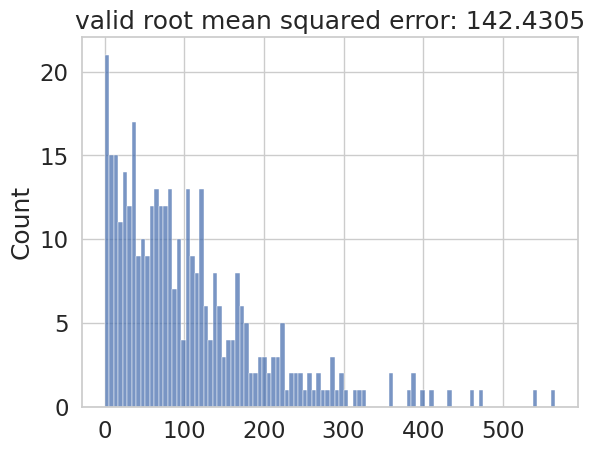

In [74]:
valid_preds = xgb_model_ts.predict(valid_X_xgb)
valid_squared_errors = (valid_y.to_numpy() - valid_preds) ** 2
plt.title(f'valid root mean squared error: {np.sqrt(valid_squared_errors.mean()):.4f}')
sns.histplot(data=np.sqrt(valid_squared_errors), stat='count', bins=100)

In [73]:
test_preds = xgb_model_ts.predict(test_df_xgb)
test_preds = shift(test_preds, -1, cval=np.NaN) 
test_preds[-1] = test_preds[-2]
test_preds = test_preds.reshape(-1, 1)
print(test_preds.shape)

submission_df = pd.DataFrame({'Id': range(1, test_df.shape[0]+1), 'Close': test_preds[:, 0]})
submission_df.to_csv('/kaggle/working/stocks_submission_xgb.csv', index=False)

(126, 1)


again, a bit higher error on validation, but on private data we've got lower error than automl

automl_score: 269220955047 * 1e7

xgb_score:    269219230548 * 1e7

the only concern is that correlation with target and original features Open, Low, High, Volume, maybe the competition's data is sketchy and contains data leak, that's not really fixable from my side

otherwise the approach seems well-thought, and if I would continue to work on this pipeline, I would test it on different datasets by barcing different indexes prices by hand